In [ ]:
# Package Load
import pickle
import pyLDAvis
import math
import copy
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tomotopy as tp
import tomotopy.coherence as tpc
from gensim.corpora import Dictionary
from datetime import datetime
from tqdm import tqdm
from datetime import datetime
from timeit import default_timer
import plotly.express as px
import plotly.offline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
version_name=str(datetime.today().strftime("%Y%m%d")) # 버전 정보 변수
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import matplotlib.font_manager as fm
import matplotlib as mpl

In [3]:
import networkx as nx
import operator
import scipy
import itertools
#pip install scipy networkx==2.6.3  # coo_array에러나면 실행

In [4]:
os.chdir("C:\\Users\\newcomer02\\NTIS_Project")

# 기존에 학습된 모델 불러오기 

In [5]:
# input : model 폴더명, 해당 폴더, 없으면 오류 발생 (원하는 버전 모델 있으면 지정, 없으면 Enter -> Default)
# model 폴더 안에 bin, npy 파일 필요, 없으면 오류 발생

lda_ver=input("불러올 LDA모델이 담긴 ./data/LDA 내 폴더 명을 입력하세요 (Default: 엔터키) : ")
topic_num = int(input("모델의 토픽 수를 입력하세요. (※ 권장값 = 180개)"))
if lda_ver=='':
    print("\nDefault LDA모델을 불러옵니다.")
    mdl=tp.LDAModel.load("./model/LDA_MODEL_20.bin")
#    lda_info =np.load("./data/LDA/Default/ict_index.npy")
else:
    print("\n%s 에 학습된 LDA모델을 불러옵니다."%(lda_ver[-8:]))
    mdl=tp.LDAModel.load("./model/"+lda_ver+"/LDA_MODEL_"+str(topic_num)+".bin")
#    lda_info =np.load("./data/LDA/"+lda_ver+"/ict_index.npy")

불러올 LDA모델이 담긴 ./data/LDA 내 폴더 명을 입력하세요 (Default: 엔터키) :  
모델의 토픽 수를 입력하세요. (※ 권장값 = 180개) 20



Default LDA모델을 불러옵니다.


# 파일 불러오기 

In [6]:
folder_name=input("사용할 데이터 폴더명을 입력하세요(Default: 엔터키): ")
lda_txt="LDA_PRED_"+ folder_name
DATA_DIR = "./data/Default/"+ folder_name+ "/"
# NKIS, NTIS, REPORT, GOV
print(DATA_DIR + lda_txt)

사용할 데이터 폴더명을 입력하세요(Default: 엔터키):  NTIS


./data/Default/NTIS/LDA_PRED_NTIS


In [7]:
# input : data/LDA 폴더에 txt 형태 코퍼스 파일, 없으면 오류 발생

corpus=[]
for n, line in tqdm(enumerate(open(DATA_DIR+lda_txt+".txt", encoding='CP949'))):
    doc=line.strip().split()
    corpus.append(doc)
print("코퍼스 파일 로드가 완료되었습니다.")

76684it [00:03, 21154.19it/s]

코퍼스 파일 로드가 완료되었습니다.


In [8]:
 ##단어 없는 것 제거
temp = []
for cnt in range(len(corpus)):
    if len(corpus[cnt])  != 0 :
        temp.append(corpus[cnt])
        
corpus = temp

In [9]:
## 불용어

from string import ascii_lowercase
from string import ascii_uppercase
alphabet_list = list(ascii_lowercase) + list(ascii_uppercase)
alphabet_list.append("ㆍ")
#+ list(topic2["0"])
#print(len(topic2["0"]))
# 52부터 topic2 51까지 알파벳 대소문자 
#alphabet_list = alphabet_list[:550] #숫자만 바꿔주면됨 
len(alphabet_list)

53

In [10]:
unusing_dic = pd.DataFrame()
unusing_dic["term"] = alphabet_list

In [11]:
temp_f =[]
remove_set =unusing_dic["term"].tolist()

for temp_1 in tqdm(corpus) :
    temp_t = [temp_2 for temp_2 in temp_1 if temp_2 not in remove_set]
    temp_f.append(temp_t)
    
corpus = temp_f

100%|██████████████████████████████████████████████████████████████████████████| 76684/76684 [00:13<00:00, 5751.01it/s]


In [19]:
wd_network = pd.read_csv("./data/Default/"+folder_name+"/LDA/"+folder_name+"_wd_network_20.csv",encoding="cp949",index_col=0)

In [25]:
#wd_network= pd.read_csv("./data/Default/"+folder_name+ "/LDA/" + folder_name+"_wd_network_"+ str(topic_num)+".csv",encoding="cp949",index_col=0)

In [ ]:
wd_network

# 단어 네트워크

In [ ]:
# lda_year = pd.read_csv("HAN_year.csv",index_col=0)
# wd_network["year"] = lda_year["year"].copy()

In [ ]:
# wd_network.to_csv("wd_network_"+ str(topic_num) + ".csv")

In [21]:
wd_network_lda = wd_network.copy()

In [22]:
timepoint = int(input("보고싶은 년도를 입력해주시오: ex)2017:0 ~ 2021:4 :"))
if timepoint == 0:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2017]
elif timepoint == 1:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2018]
elif timepoint == 2:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2019]
elif timepoint == 3:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2020]
elif timepoint == 4:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2021]

보고싶은 년도를 입력해주시오: ex)2017:0 ~ 2021:4 : 4


In [23]:
topic_num=int(input("분석하고 싶은 토픽 번호를 입력하십시오:"))

분석하고 싶은 토픽 번호를 입력하십시오: 14


In [24]:
## 토픽 별 상위 1000개 데이터를 이용한 사전 생성 
using_word= []
for i in range(500):
    using_word.append(mdl.get_topic_words(topic_num-1,top_n=500)[i][0]) 

In [ ]:
df = pd.DataFrame()
for i in tqdm(range(100)):
    temp = wd_network[wd_network["Topic"]==topic_num].sort_values("Topic_prob",ascending=False).iloc[i][0]
    temp2 = []
    for j in (temp.split(" ")):
        if j in using_word:
            temp2.append(j)
        else:
            continue
    count = {}
    for c,a in tqdm(enumerate(temp2)):  # i는 숫자 a는 1행 
        for b in temp2[c+1:]:
            if a>b:
                count[b,a] = count.get((b,a),0)+1
            else:
                count[a,b] = count.get((a,b),0)+1
    word_df = pd.DataFrame.from_dict(count,orient="index")  
    df = pd.concat([df,word_df])

In [26]:
df.reset_index(inplace=True)
df[1] = pd.DataFrame(df["index"].tolist())[0]
df[2] = pd.DataFrame(df["index"].tolist())[1]
df = df[df[1]!=df[2]]
df= pd.DataFrame(df.groupby("index")[0].sum())
df

,0
index,
"(1, 100)",36
"(1, 2)",42
"(1, 3)",7
"(1, 30)",4
"(1, 4)",11
...,...
"(환경, 효율)",9
"(환경, 효율성)",1
"(환경, 히)",1


In [27]:
list1 = []
for i in range(len(df)):
    list1.append([df.index[i][0],df.index[i][1],df[0][i]])

In [28]:
df2 = pd.DataFrame(list1,columns=["term1","term2","freq"])
df3 = df2.sort_values(by=["freq"],ascending=False)
df3 = df3.reset_index(drop=True)

In [32]:
df3.to_csv("zzz.csv",index=False,encoding="cp949")

In [23]:
i =1
while len((np.where(df3["freq"]>=i))[0])>100:
    i +=1
freq_num=i
print(freq_num)

638


In [24]:
G_centrality = nx.Graph()
for i in tqdm(range(len((np.where(df3["freq"]>=freq_num))[0]))):
    G_centrality.add_edge(df3["term1"][i],df3["term2"][i],weight=int(df3["freq"][i]))

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 24988.41it/s]


In [ ]:
dgr = nx.degree_centrality(G_centrality)      #연결 중심성
btw = nx.betweenness_centrality(G_centrality) #매개 중심성
cls = nx.closeness_centrality(G_centrality)   #근접 중심성
egv = nx.eigenvector_centrality(G_centrality) #고유벡터 중심성
pgr = nx.pagerank(G_centrality) #페이지랭크 안됨 

In [ ]:
sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
G= nx.Graph()

In [ ]:
for i in tqdm(range(len(sorted_pgr))):
    G.add_node(sorted_pgr[i][0],nodesize=sorted_dgr[i][1])

for i in tqdm(range(len((np.where(df3["freq"]>=freq_num))[0]))):
    G.add_weighted_edges_from([(df3["term1"][i],df3["term2"][i],int(df3["freq"][i]))])

In [ ]:
sizes = [G.nodes[node]["nodesize"]*2000 for node in G]

## 텍스트 네트워크 폰트 설정 및 그래프 그리기
#### <에러나면 아래로 가서 패키지 실행 후 올라오기>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
## 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
font_fname = "C:\\Windows\\Fonts\\NanumGothicCoding-bold.ttf"
fontprop = fm.FontProperties(fname=font_fname,size=10).get_name()

In [ ]:
options={
    "edge_color":'#FFDEA2',
    "width":1,
    "with_labels":True,
    "font_weight":"bold",
}

In [ ]:
#pos=nx.fruchterman_reingold_layout(G)
#pos=nx.spectral_layout(G)
#pos=nx.random_layout(G)
#pos=nx.shell_layout(G)
#pos=nx.circular_layout(G)
#pos=nx.spring_layout(G,k=3.5,iterations=100)
#pos=nx.kamada_kawai_layout(G)

plt.figure(figsize=(16,8)); 
nx.draw_networkx(G,node_size=sizes,pos=nx.kamada_kawai_layout(G),**options,font_family=fontprop)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555")
#plt.savefig("temp.png", bbox_inches='tight')
plt.show()

In [ ]:
timepoint

In [ ]:
#pos=nx.fruchterman_reingold_layout(G)
#pos=nx.spectral_layout(G)
#pos=nx.random_layout(G)
#pos=nx.shell_layout(G)
#pos=nx.circular_layout(G)
#pos=nx.spring_layout(G,k=3.5,iterations=100)
#pos=nx.kamada_kawai_layout(G)

plt.figure(figsize=(16,8)); 
nx.draw_networkx(G,node_size=sizes,pos=nx.spring_layout(G,k=3.5,iterations=100),**options,font_family=fontprop)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555")
plt.savefig(".\\data\\Default\\NTIS\\LDA\\Topic_Network\\Topic"+ str(topic_num) +"_"+ str(timepoint+2017) +".png", bbox_inches='tight')
plt.show()

In [ ]:
print("** degree **")
for x in range(len(G)):
    print(sorted_dgr[x])

In [ ]:
print("** betweenness **")
for x in range(len(G)):
    print(sorted_btw[x])

In [ ]:
print("** closeness **")
for x in range(len(G)):
    print(sorted_cls[x])

## 최초 1회 실행

In [ ]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

In [ ]:
print ('설정파일 위치: ', mpl.matplotlib_fname())

In [ ]:
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

In [ ]:
plt.rc("font", family="NanumGothicCoding")
print(plt.rcParams["font.family"])

In [ ]:
#단어끼리 서로 빈도를 세는 데이터셋을 만들었을 때 Gaphi로 시각화하는 것 전단계: graphml 확장자 형식으로 만들기
class MakeGraphml:
    def make_graphml(self, pair_file, graphml_file):
        out = open(graphml_file, 'w', encoding = 'utf-8')
        entity = []
        e_dict = {}
        count = []
        for i in range(len(pair_file)):
            e1 = pair_file.iloc[i,0]
            e2 = pair_file.iloc[i,1]
            #frq = ((word_dict[e1], word_dict[e2]),  pair.split('\t')[2])
            frq = ((e1, e2), pair_file.iloc[i,2])
            if frq not in count: count.append(frq)   # ((a, b), frq)
            if e1 not in entity: entity.append(e1)
            if e2 not in entity: entity.append(e2)
        print('# terms: %s'% len(entity))
        #create e_dict {entity: id} from entity
        for i, w in enumerate(entity):
            e_dict[w] = i + 1 # {word: id}
        out.write(
            "<?xml version=\"1.0\" encoding=\"UTF-8\"?><graphml xmlns=\"http://graphml.graphdrawing.org/xmlns\" xmlns:xsi=\"http://www.w3.org/2001/XMLSchema-instance\" xsi:schemaLocation=\"http://graphml.graphdrawing.org/xmlnshttp://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd\">" +
            "<key id=\"d1\" for=\"edge\" attr.name=\"weight\" attr.type=\"double\"/>" +
            "<key id=\"d0\" for=\"node\" attr.name=\"label\" attr.type=\"string\"/>" +
            "<graph id=\"Entity\" edgedefault=\"undirected\">" + "\n")
        # nodes
        for i in entity:
            out.write("<node id=\"" + str(e_dict[i]) +"\">" + "\n")
            out.write("<data key=\"d0\">" + i + "</data>" + "\n")
            out.write("</node>")
        # edges
        for y in range(len(count)):
            out.write("<edge source=\"" + str(e_dict[count[y][0][0]]) + "\" target=\"" + str(e_dict[count[y][0][1]]) + "\">" + "\n")
            out.write("<data key=\"d1\">" + str(count[y][1]) + "</data>" + "\n")
            #out.write("<edge source=\"" + str(count[y][0][0]) + "\" target=\"" + str(count[y][0][1]) +"\">"+"\n")
            #out.write("<data key=\"d1\">" + str(count[y][1]) +"</data>"+"\n")
            out.write("</edge>")
        out.write("</graph> </graphml>")
        print('now you can see %s' % graphml_file)
        #pairs.close()
        out.close()

In [ ]:
gm = MakeGraphml()

In [ ]:
graphml_file = 'wd_network.graphml'

In [ ]:
gm.make_graphml(df3.iloc[0:len((np.where(df3["freq"]>=5))[0]),:], graphml_file)

# 깨진 파일 1개 자동

In [26]:
wd_network_lda = wd_network.copy() ## 최초 한번만 실행 그 후로 실행x

In [48]:
topic_num=int(input("분석하고 싶은 토픽 번호를 입력하십시오:"))
timepoint = int(input("보고싶은 년도를 입력해주시오: ex)2017:0 ~ 2021:4 :"))
if timepoint == 0:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2017]
elif timepoint == 1:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2018]
elif timepoint == 2:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2019]
elif timepoint == 3:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2020]
elif timepoint == 4:
    wd_network  = wd_network_lda[wd_network_lda["year"]==2021]

분석하고 싶은 토픽 번호를 입력하십시오: 19
보고싶은 년도를 입력해주시오: ex)2017:0 ~ 2021:4 : 3


C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:108: DeprecationWarning:

networkx.pagerank_scipy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.



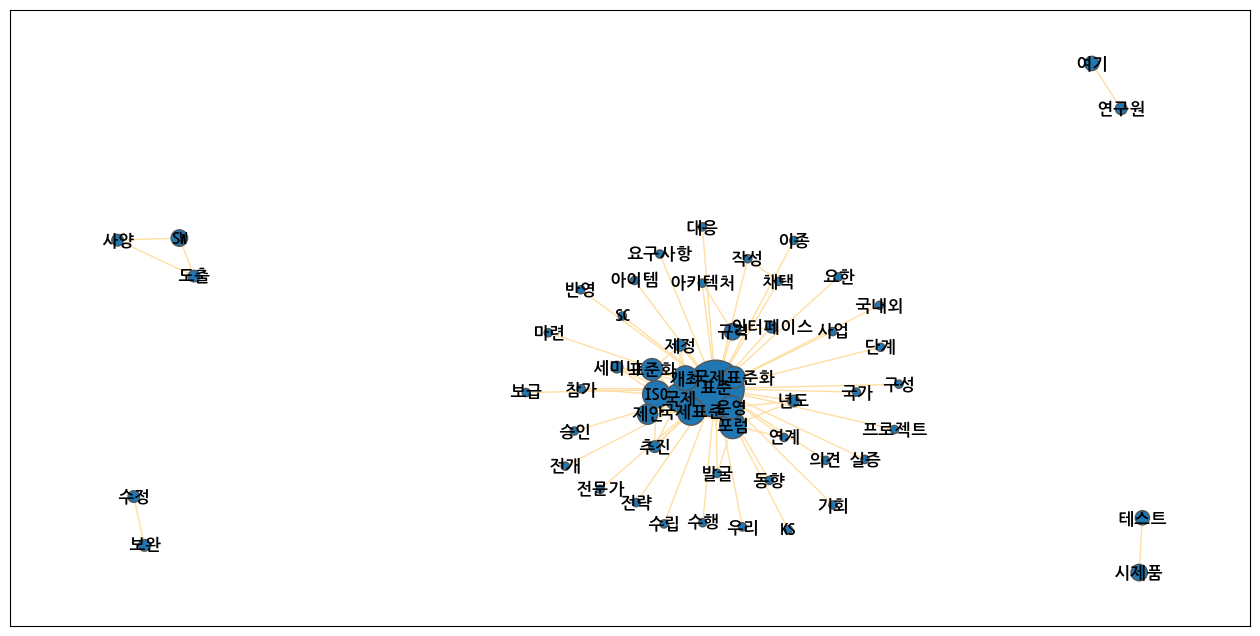

In [49]:
using_word= []
for i in range(500):
    using_word.append(mdl.get_topic_words(topic_num-1,top_n=500)[i][0]) 
    
df = pd.DataFrame()
for i in range(100):
    temp = wd_network[wd_network["Topic"]==topic_num].sort_values("Topic_prob",ascending=False).iloc[i][0]
    temp2 = []
    for j in (temp.split(" ")):
        if j in using_word:
            temp2.append(j)
        else:
            continue
    count = {}
    for c,a in enumerate(temp2):  # i는 숫자 a는 1행 
        for b in temp2[c+1:]:
            if a>b:
                count[b,a] = count.get((b,a),0)+1
            else:
                count[a,b] = count.get((a,b),0)+1
    word_df = pd.DataFrame.from_dict(count,orient="index")  
    df = pd.concat([df,word_df])
    
df.reset_index(inplace=True)
df[1] = pd.DataFrame(df["index"].tolist())[0]
df[2] = pd.DataFrame(df["index"].tolist())[1]
df = df[df[1]!=df[2]]
df= pd.DataFrame(df.groupby("index")[0].sum())

list1 = []
for i in range(len(df)):
    list1.append([df.index[i][0],df.index[i][1],df[0][i]])
    
df2 = pd.DataFrame(list1,columns=["term1","term2","freq"])
df3 = df2.sort_values(by=["freq"],ascending=False)
df3 = df3.reset_index(drop=True)

i =1
while len((np.where(df3["freq"]>=i))[0])>100:
    i +=1
freq_num=i

G_centrality = nx.Graph()
for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
    G_centrality.add_edge(df3["term1"][i],df3["term2"][i],weight=int(df3["freq"][i]))
    
dgr = nx.degree_centrality(G_centrality)      #연결 중심성
btw = nx.betweenness_centrality(G_centrality) #매개 중심성
cls = nx.closeness_centrality(G_centrality)   #근접 중심성
egv = nx.eigenvector_centrality(G_centrality) #고유벡터 중심성
pgr = nx.pagerank(G_centrality) #페이지랭크 안됨 

sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

G= nx.Graph()

for i in range(len(sorted_pgr)):
    G.add_node(sorted_pgr[i][0],nodesize=sorted_dgr[i][1])

for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
    G.add_weighted_edges_from([(df3["term1"][i],df3["term2"][i],int(df3["freq"][i]))])
    
sizes = [G.nodes[node]["nodesize"]*2000 for node in G]

font_fname = "C:\\Windows\\Fonts\\NanumGothicCoding-bold.ttf"
fontprop = fm.FontProperties(fname=font_fname,size=10).get_name()

options={
    "edge_color":'#FFDEA2',
    "width":1,
    "with_labels":True,
    "font_weight":"bold",
}

plt.figure(figsize=(16,8)); 
nx.draw_networkx(G,node_size=sizes,pos=nx.spring_layout(G,k=3.5,iterations=100),**options,font_family=fontprop)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555")
plt.savefig(".\\data\\Default\\"+folder_name+"\\LDA\\Topic_Network_"+folder_name+"\\Topic"+ str(topic_num) +"_"+str(timepoint+2017)+".png", bbox_inches='tight')
plt.show()

# 자동

In [15]:
wd_network_lda = wd_network.copy() ##최초 1회만 실행

In [16]:
year_range = input("사용년도의 범위를 입력하시오 ex)2017~2021:5 :")
topic_len = input("토픽의 개수를 입력하시오:")

사용년도의 범위를 입력하시오 ex)2017~2021:5 : 5
토픽의 개수를 입력하시오: 20


In [ ]:
for timepoint in tqdm(range(int(year_range))):

    if timepoint == 0:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2017]
    elif timepoint == 1:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2018]
    elif timepoint == 2:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2019]
    elif timepoint == 3:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2020]
    elif timepoint == 4:
        wd_network  = wd_network_lda[wd_network_lda["year"]==2021]
        

    for topic_num in tqdm(range(int(topic_len))):
        using_word= []
        for i in range(500):
            using_word.append(mdl.get_topic_words(topic_num,top_n=500)[i][0]) 
            
        df = pd.DataFrame()
        if len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False)) < 100:
            a = len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False))
        else :
            a = 100 
        for i in range(a):
            temp = wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False).iloc[i][0]
            temp2 = []
            for j in (temp.split(" ")):
                if j in using_word:
                    temp2.append(j)
                else:
                    continue
            count = {}
            for c,a in enumerate(temp2):  # i는 숫자 a는 1행 
                for b in temp2[c+1:]:
                    if a>b:
                        count[b,a] = count.get((b,a),0)+1
                    else:
                        count[a,b] = count.get((a,b),0)+1
            word_df = pd.DataFrame.from_dict(count,orient="index")  
            df = pd.concat([df,word_df])
            
        df.reset_index(inplace=True)
        df[1] = pd.DataFrame(df["index"].tolist())[0]
        df[2] = pd.DataFrame(df["index"].tolist())[1]
        df = df[df[1]!=df[2]]
        df= pd.DataFrame(df.groupby("index")[0].sum())
        
        list1 = []
        for i in range(len(df)):
            list1.append([df.index[i][0],df.index[i][1],df[0][i]])
            
        df2 = pd.DataFrame(list1,columns=["term1","term2","freq"])
        df3 = df2.sort_values(by=["freq"],ascending=False)
        df3 = df3.reset_index(drop=True)
        
        i =1
        while len((np.where(df3["freq"]>=i))[0])>100:
            i +=1
        freq_num=i
        
        G_centrality = nx.Graph()
        for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
            G_centrality.add_edge(df3["term1"][i],df3["term2"][i],weight=int(df3["freq"][i]))
            
        dgr = nx.degree_centrality(G_centrality)      #연결 중심성
        btw = nx.betweenness_centrality(G_centrality) #매개 중심성
        cls = nx.closeness_centrality(G_centrality)   #근접 중심성
        egv = nx.eigenvector_centrality(G_centrality, tol=1.0e-3) #고유벡터 중심성
        pgr = nx.pagerank(G_centrality) #페이지랭크 안됨 
        
        sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
        sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
        sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
        sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
        sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)
        
        G= nx.Graph()
        
        for i in range(len(sorted_pgr)):
            G.add_node(sorted_pgr[i][0],nodesize=sorted_dgr[i][1])
        for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
            G.add_weighted_edges_from([(df3["term1"][i],df3["term2"][i],int(df3["freq"][i]))])
        
        sizes = [G.nodes[node]["nodesize"]*2000 for node in G]
        
        ## 마이너스 폰트 깨지는 문제에 대한 대처
        mpl.rcParams['axes.unicode_minus'] = False
        font_fname = "C:\\Windows\\Fonts\\NanumGothicCoding-bold.ttf"
        fontprop = fm.FontProperties(fname=font_fname,size=10).get_name()
        
        options={
            "edge_color":'#FFDEA2',
            "width":1,
            "with_labels":True,
            "font_weight":"bold",
        }
        
        plt.figure(figsize=(16,8)); 
        nx.draw_networkx(G,node_size=sizes,pos=nx.kamada_kawai_layout(G),**options,font_family=fontprop)
        ax = plt.gca()
        ax.collections[0].set_edgecolor("#555555")
        
        plt.savefig(".\\data\\Default\\"+folder_name+"\\LDA\\Topic_Network_"+folder_name+"\\Topic" + str(topic_num+1) +"_"+str(timepoint+2017)+".png", bbox_inches='tight')

# 토픽 별 텍스트 네트워크 자동

In [35]:
topic_num = 41 

In [ ]:
for topic_num in tqdm(range(int(topic_num))):
    using_word= []
    for i in range(500):
        using_word.append(mdl.get_topic_words(topic_num,top_n=500)[i][0]) 

    df = pd.DataFrame()
    if len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False)) < 100:
        a = len(wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False))
    else :
        a = 100 
    for i in range(a):
        temp = wd_network[wd_network["Topic"]==topic_num+1].sort_values("Topic_prob",ascending=False).iloc[i][0]
        temp2 = []
        for j in (temp.split(" ")):
            if j in using_word:
                temp2.append(j)
            else:
                continue
        count = {}
        for c,a in enumerate(temp2):  # i는 숫자 a는 1행 
            for b in temp2[c+1:]:
                if a>b:
                    count[b,a] = count.get((b,a),0)+1
                else:
                    count[a,b] = count.get((a,b),0)+1
        word_df = pd.DataFrame.from_dict(count,orient="index")  
        df = pd.concat([df,word_df])

    df.reset_index(inplace=True)
    df[1] = pd.DataFrame(df["index"].tolist())[0]
    df[2] = pd.DataFrame(df["index"].tolist())[1]
    df = df[df[1]!=df[2]]
    df= pd.DataFrame(df.groupby("index")[0].sum())

    list1 = []
    for i in range(len(df)):
        list1.append([df.index[i][0],df.index[i][1],df[0][i]])

    df2 = pd.DataFrame(list1,columns=["term1","term2","freq"])
    df3 = df2.sort_values(by=["freq"],ascending=False)
    df3 = df3.reset_index(drop=True)

    i =1
    while len((np.where(df3["freq"]>=i))[0])>100:
        i +=1
    freq_num=i

    G_centrality = nx.Graph()
    for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
        G_centrality.add_edge(df3["term1"][i],df3["term2"][i],weight=int(df3["freq"][i]))

    dgr = nx.degree_centrality(G_centrality)      #연결 중심성
    btw = nx.betweenness_centrality(G_centrality) #매개 중심성
    cls = nx.closeness_centrality(G_centrality)   #근접 중심성
    egv = nx.eigenvector_centrality(G_centrality, tol=1.0e-3) #고유벡터 중심성
    pgr = nx.pagerank(G_centrality) #페이지랭크 안됨 

    sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
    sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
    sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
    sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
    sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

    G= nx.Graph()

    for i in range(len(sorted_pgr)):
        G.add_node(sorted_pgr[i][0],nodesize=sorted_dgr[i][1])
    for i in range(len((np.where(df3["freq"]>=freq_num))[0])):
        G.add_weighted_edges_from([(df3["term1"][i],df3["term2"][i],int(df3["freq"][i]))])

    sizes = [G.nodes[node]["nodesize"]*2000 for node in G]

    ## 마이너스 폰트 깨지는 문제에 대한 대처
    mpl.rcParams['axes.unicode_minus'] = False
    font_fname = "C:\\Windows\\Fonts\\NanumGothicCoding-bold.ttf"
    fontprop = fm.FontProperties(fname=font_fname,size=10).get_name()

    options={
        "edge_color":'#FFDEA2',
        "width":1,
        "with_labels":True,
        "font_weight":"bold",
    }

    plt.figure(figsize=(16,8)); 
    nx.draw_networkx(G,node_size=sizes,pos=nx.kamada_kawai_layout(G),**options,font_family=fontprop)
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555")

    plt.savefig("C:\\Users\\newcomer02\\NTIS_Project\\data\\Default\\NTIS\\LDA\\Topic_Network_NTIS_all\\Topic" + str(topic_num+1) + ".png", bbox_inches='tight')

# 보고서 쓰기위한 워드 데이터프레임 생성

In [25]:
wd_network = pd.read_excel("./data/Default/"+folder_name+"/LDA/"+folder_name+"_wd_network_topic_20.xlsx",index_col=0)
from collections import Counter
han_year = pd.read_csv("./data/Default/"+folder_name+"/HAN_year_" + folder_name+ ".csv",index_col=0)
wd_network["year"] = han_year
wd_network_lda = wd_network.copy()

In [32]:
df = pd.DataFrame()
for c in range(2017,2022):
    wd_network = wd_network_lda[wd_network_lda["year"]==c]
    final = []
    for j in range(topic_num):
        temp= []
        temp2 = []
        using_word = np.array(mdl.get_topic_words(j,500))[:,0].tolist()
        wd = wd_network[wd_network["Topic"]==j+1]
        for i in range(len(wd)):
            temp.append(wd["corpus"].iloc[i].split(" "))
        temp = sum(temp,[])
        all_word =Counter(temp).most_common()
        for i in (np.array(all_word)[:,0].tolist()):
            if i in using_word:
                temp2.append(i)
                if len(temp2)== 10:
                    break
        final.append(temp2)
    df = pd.concat([df,pd.Series(final)],axis=1)

In [33]:
df.columns=range(2017,2022)
df.index = df.index+1

In [31]:
df.to_excel("./data/Default/"+folder_name+"/LDA/"+folder_name+"토픽별 주요 단어.xlsx",index=False)

In [34]:
df

,2017,2018,2019,2020,2021
1,"[소자, 반도체, 물질, 소재, 응용, 박막, 나노, 차세대, 에서, 광]","[소자, 반도체, 물질, 소재, 응용, 박막, 광, 양자, 나노, 에서]","[소자, 반도체, 물질, 소재, 응용, 박막, 양자, 산화물, 나노, 2차원]","[소자, 반도체, 소재, 물질, 양자, 응용, 박막, 나노, 차세대, 발광]","[소자, 소재, 반도체, 물질, 양자, 응용, 차세대, 박막, 디스플레이, 2차원]"
2,"[측정, LED, 용, 방식, 레이저, 이상, 광, 카메라, 렌즈, 조명]","[측정, LED, 카메라, 방식, 이상, 레이저, 용, 출력, 렌즈, 온도]","[측정, LED, 이상, 온도, 카메라, 조명, 방식, 레이저, 용, 출력]","[측정, LED, 이상, 용, 레이저, 조명, 카메라, 온도, 신호, 방식]","[측정, 레이저, LED, 이상, 용, 온도, 신호, 렌즈, 광학, 방식]"
3,"[SW, 빅데이터, 자동, 수집, 클라우드, 처리, 서버, 생성, 검색, 사용자]","[SW, 빅데이터, 자동, 수집, 처리, 클라우드, 품질, 서버, 솔루션, 생성]","[빅데이터, SW, 수집, 자동, 처리, AI, 스마트팜, 생성, 클라우드, 서버]","[빅데이터, SW, AI, 수집, 자동, 처리, 솔루션, 생성, 이상, 서버]","[AI, 수집, 빅데이터, SW, 자동, 처리, 솔루션, 딥러닝, 작물, 운영]"
4,"[진단, 의료, 치료, 측정, 임상, 프로그램, 질환, 암, 자의, 년도]","[진단, 의료, 치료, 임상, 측정, 프로그램, 암, 년도, 질환, 건강]","[진단, 의료, 치료, 임상, 측정, 프로그램, 질환, 자의, 딥러닝, 모니터링]","[진단, 의료, 치료, 임상, 측정, 질환, 프로그램, 병원, 딥러닝, 년도]","[진단, 의료, 치료, 임상, 측정, AI, 프로그램, 질환, 암, 모니터링]"
5,"[생산, 장비, 검사, 계획, 경쟁력, 품질, 인력, 억, 수출, 자동]","[생산, 장비, 검사, 작업, 자동, 계획, 품질, 인력, 이상, 경쟁력]","[생산, 장비, 검사, 작업, 자동, 이상, 품질, 설비, 제조, 억]","[생산, 장비, 검사, 제조, 설비, 품질, 작업, 부품, 이상, 자동]","[생산, 장비, 검사, 제조, 자동화, 자동, 품질, 작업, 설비, 부품]"
6,"[기업, 교육, 양성, 사업, 인력, 글로벌, SW, 융합, 경쟁력, 창출]","[교육, 기업, 양성, 사업, SW, 인력, 글로벌, 융합, 경쟁력, 창출]","[교육, 양성, 기업, 사업, SW, 인력, 글로벌, 융합, 경쟁력, 창출]","[교육, 양성, 기업, 사업, 글로벌, 융합, 인력, 창출, 인재, AI]","[교육, 기업, 양성, AI, 사업, 융합, 창출, 인력, 글로벌, 운영]"
7,"[사용자, 모바일, 디자인, 고객, 콘텐츠, 앱, 자의, 스마트폰, 상품, 광고]","[사용자, 고객, 콘텐츠, 앱, 추천, 자의, 모바일, 연동, 상품, 디자인]","[사용자, 추천, 고객, 디자인, 상품, 자의, 앱, 모바일, 콘텐츠, 연동]","[사용자, 고객, 추천, 상품, 앱, 자의, 모바일, 콘텐츠, 디자인, 솔루션]","[사용자, 추천, AI, 고객, 상품, 앱, 솔루션, 디자인, 콘텐츠, 연동]"
8,"[방법, 문제, 에서, 기법, 제시, 모형, 과정, 자료, 요한, 이]","[방법, 문제, 기법, 에서, 모형, 딥러닝, 제시, 응용, 제안, 자료]","[방법, 문제, 기법, 에서, 모형, 딥러닝, 제시, 제안, 응용, 양자]","[방법, 문제, 기법, 딥러닝, 에서, 모형, 제시, 제안, 응용, 자료]","[방법, 문제, 딥러닝, 기법, 에서, 모형, 제시, 제안, 양자, 응용]"
9,"[콘텐츠, VR, 게임, 교육, 사용자, 미디어, 가상현실, 방송, AR, 모바일]","[콘텐츠, VR, 교육, 게임, AR, 사용자, 가상현실, 모바일, 컨텐츠, 방송]","[콘텐츠, VR, 교육, AR, 게임, 사용자, 가상현실, 비디오, 공간, 방송]","[콘텐츠, VR, 교육, AR, 사용자, 게임, 가상현실, 비디오, 공간, 미디어]","[콘텐츠, 교육, VR, AR, 사용자, 비디오, 가상현실, 게임, 공간, XR]"
10,"[에너지, 전력, 발전, 충전, 태양광, 절감, 설비, 모니터링, 진단, 측면]","[에너지, 전력, 충전, DC, 태양광, 운영, 발전, 배터리, ESS, 절감]","[에너지, 전력, 운영, 충전, 발전, DC, ESS, 설비, 태양광, 배터리]","[에너지, 전력, 운영, 배터리, 충전, 발전, 모니터링, 설비, 태양광, ESS]","[에너지, 운영, 배터리, 전력, 태양광, 충전, 설비, 발전, 실증, 모니터링]"
